# Scientific Data Analysis
Jasper Wink, 14616513 \
Dennis van der Werff, 1462189

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.api import VAR

import statsmodels.api as sm


In [2]:
# Read data
cn = pd.read_csv("data/cryptonews.csv")
bp = pd.read_csv("data/btc.csv")

Group the data for each month. \
Determine the amount of articles for each month. \
Determine the mean opening bitcoin price for each month.

In [3]:
# Convert the date to the datetime format
cn['date'] = pd.to_datetime(cn['date'], format='%Y-%m-%d %H:%M:%S')
bp['date'] = pd.to_datetime(bp['Date'], format='%Y-%m-%d')

# Discard unnecairy date data, eg. hours, minutes etc
cn['weeks'] = cn['date'].dt.to_period('W')
bp['weeks'] = bp['date'].dt.to_period('W')

# Extract the polarity field out of the cn dataset
cn['sentiment'] = cn['sentiment'].apply(ast.literal_eval)
cn['polarity'] = cn['sentiment'].apply(lambda x: x['polarity'])

# Group data by the weeks
bp_weekly_open = bp.groupby('weeks')['Open'].mean().reset_index(name='open_mean')
bp_weekly_volume = bp.groupby('weeks')['Volume'].mean().reset_index(name='volume_mean')
bp_weekly_data = pd.merge(bp_weekly_open, bp_weekly_volume, on='weeks', how='inner')

cn_weekly_count = cn.groupby('weeks').size().reset_index(name='count')
cn_weekly_sentiment = cn.groupby('weeks')['polarity'].mean().reset_index(name='polarity_mean')
cn_weekly_data = pd.merge(cn_weekly_count, cn_weekly_sentiment, on='weeks', how='inner')

weekly_data = pd.merge(bp_weekly_data, cn_weekly_data, on='weeks', how='inner')
print(weekly_data.head())



                   weeks     open_mean   volume_mean  count  polarity_mean
0  2021-12-27/2022-01-02  46996.300000  2.626712e+10      4       0.240000
1  2022-01-03/2022-01-09  44245.300000  3.945468e+10     56       0.047857
2  2022-01-10/2022-01-16  42755.914286  2.849626e+10    121       0.067851
3  2022-01-17/2022-01-23  40243.542857  2.804658e+10    229       0.066419
4  2022-01-24/2022-01-30  37111.985714  2.553249e+10    250       0.081000


# Data Visualization

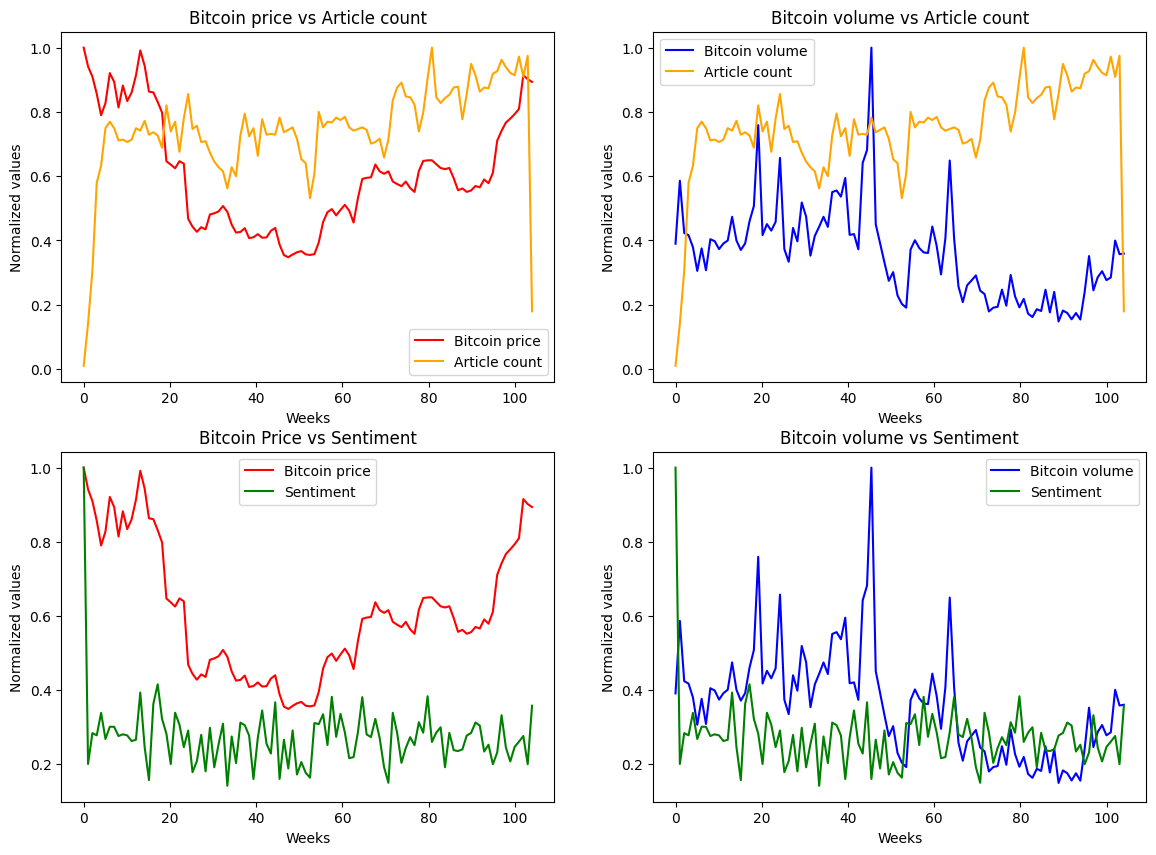

In [4]:
# Normalize the data
count_list = list(weekly_data['count'])
normalized_count = [count / max(count_list) for count in count_list]

sentiment_list = list(weekly_data['polarity_mean'])
normalized_sentiment = [sentiment / max(sentiment_list) for sentiment in sentiment_list]

open_list = list(weekly_data['open_mean'])
normalized_price = [open / max(open_list) for open in open_list]

volume_list = list(weekly_data['volume_mean'])
normalized_volume = [volume / max(volume_list) for volume in volume_list]


x = np.linspace(0, len(normalized_count), len(normalized_count))
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Bitcoin Price vs Article Count
axes[0, 0].plot(x, normalized_price, label='Bitcoin price', color='red')
axes[0, 0].plot(x, normalized_count, label='Article count', color='orange')
axes[0, 0].set_title('Bitcoin price vs Article count')
axes[0, 0].set_xlabel('Weeks')
axes[0, 0].set_ylabel('Normalized values')
axes[0, 0].legend()

# Bitcoin Volume vs Article Count
axes[0, 1].plot(x, normalized_volume, label='Bitcoin volume', color='blue')
axes[0, 1].plot(x, normalized_count, label='Article count', color='orange')
axes[0, 1].set_title('Bitcoin volume vs Article count')
axes[0, 1].set_xlabel('Weeks')
axes[0, 1].set_ylabel('Normalized values')
axes[0, 1].legend()

# Bitcoin Price vs Sentiment
axes[1, 0].plot(x, normalized_price, label='Bitcoin price', color='red')
axes[1, 0].plot(x, normalized_sentiment, label='Sentiment', color='green')
axes[1, 0].set_title('Bitcoin Price vs Sentiment')
axes[1, 0].set_xlabel('Weeks')
axes[1, 0].set_ylabel('Normalized values')
axes[1, 0].legend()

# Bitcoin Volume vs Sentiment
axes[1, 1].plot(x, normalized_volume, label='Bitcoin volume', color='blue')
axes[1, 1].plot(x, normalized_sentiment, label='Sentiment', color='green')
axes[1, 1].set_title('Bitcoin volume vs Sentiment')
axes[1, 1].set_xlabel('Weeks')
axes[1, 1].set_ylabel('Normalized values')
axes[1, 1].legend()

plt.show()


# Stationary test

Using the Augmented Dickey-Fuller (ADF) test to check if the current data is satationary. If the p-value scores lower than 0.05 we reject the $H_0$ and determine that the data is stationary.

In [5]:
# Test if the adfuller test scores lower than p-value = 0.05.
def test_stationary(data, name):
    ad_fuller_result = adfuller(data.dropna())
    if ad_fuller_result[1] > 0.05:
        print(f'{name} is not stationary | p-value: {ad_fuller_result[1]}')
    else:
        print(f'{name} is stationary | p-value: {ad_fuller_result[1]}')


# Prepair the data, by differentiating if needed.
weekly_data['open_diff'] = weekly_data['open_mean'].diff()
test_stationary(weekly_data['open_diff'], 'Bitcoin price')

weekly_data['volume_diff'] = weekly_data['volume_mean'].diff()
test_stationary(weekly_data['volume_diff'], 'Bitcoin volume')

test_stationary(weekly_data['count'], 'Article count')

test_stationary(weekly_data['polarity_mean'], 'News polarity')

Bitcoin price is stationary | p-value: 4.4567176804253537e-13
Bitcoin volume is stationary | p-value: 6.038046780346206e-13
Article count is stationary | p-value: 4.5240581131031196e-05
News polarity is stationary | p-value: 1.3517752025053774e-29


# Stationary Data visualisation

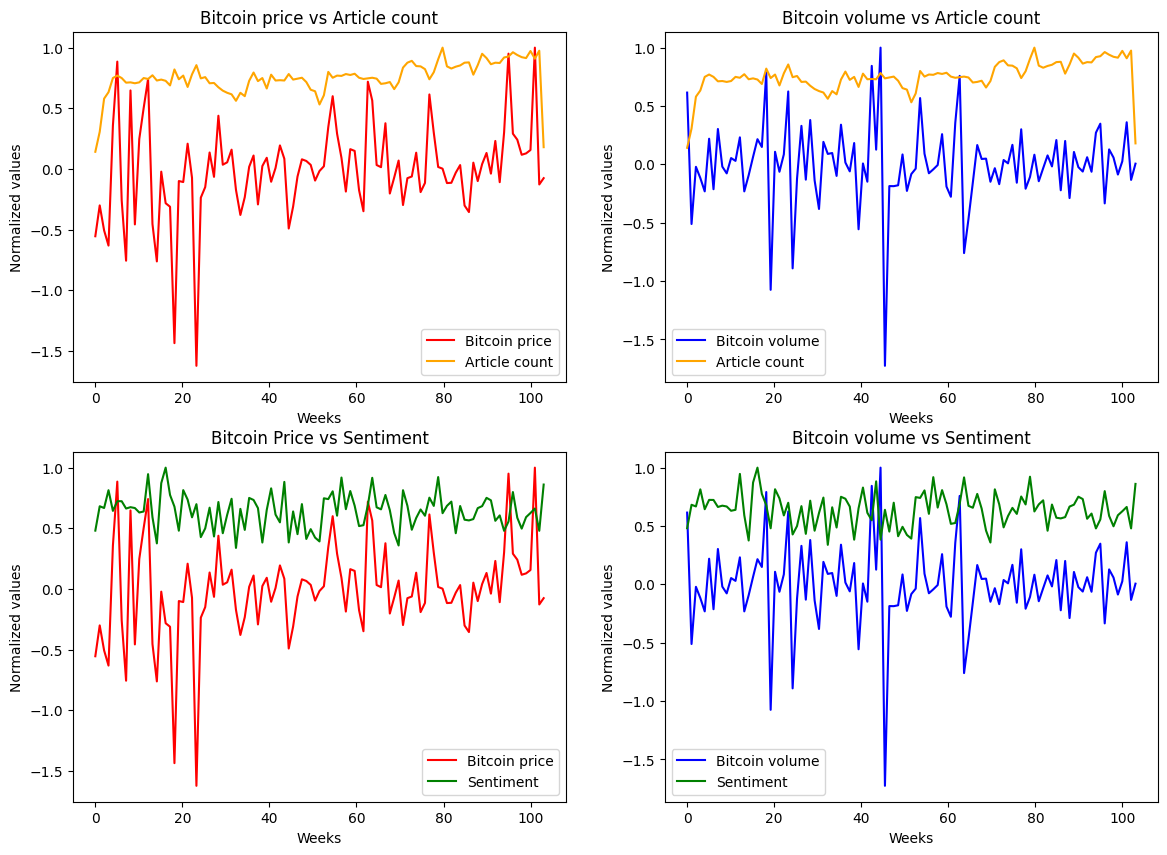

In [6]:
# Normalize the data
count_list = list(weekly_data['count'][1:])
normalized_count = [count / max(count_list) for count in count_list]

sentiment_list = list(weekly_data['polarity_mean'][1:])
normalized_sentiment = [sentiment / max(sentiment_list) for sentiment in sentiment_list]

open_list = list(weekly_data['open_diff'].dropna())
normalized_price = [open / max(open_list) for open in open_list]

volume_list = list(weekly_data['volume_diff'].dropna())
normalized_volume = [volume / max(volume_list) for volume in volume_list]


x = np.linspace(0, len(normalized_count), len(normalized_count))
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Bitcoin Price vs Article Count
axes[0, 0].plot(x, normalized_price, label='Bitcoin price', color='red')
axes[0, 0].plot(x, normalized_count, label='Article count', color='orange')
axes[0, 0].set_title('Bitcoin price vs Article count')
axes[0, 0].set_xlabel('Weeks')
axes[0, 0].set_ylabel('Normalized values')
axes[0, 0].legend()

# Bitcoin Volume vs Article Count
axes[0, 1].plot(x, normalized_volume, label='Bitcoin volume', color='blue')
axes[0, 1].plot(x, normalized_count, label='Article count', color='orange')
axes[0, 1].set_title('Bitcoin volume vs Article count')
axes[0, 1].set_xlabel('Weeks')
axes[0, 1].set_ylabel('Normalized values')
axes[0, 1].legend()

# Bitcoin Price vs Sentiment
axes[1, 0].plot(x, normalized_price, label='Bitcoin price', color='red')
axes[1, 0].plot(x, normalized_sentiment, label='Sentiment', color='green')
axes[1, 0].set_title('Bitcoin Price vs Sentiment')
axes[1, 0].set_xlabel('Weeks')
axes[1, 0].set_ylabel('Normalized values')
axes[1, 0].legend()

# Bitcoin Volume vs Sentiment
axes[1, 1].plot(x, normalized_volume, label='Bitcoin volume', color='blue')
axes[1, 1].plot(x, normalized_sentiment, label='Sentiment', color='green')
axes[1, 1].set_title('Bitcoin volume vs Sentiment')
axes[1, 1].set_xlabel('Weeks')
axes[1, 1].set_ylabel('Normalized values')
axes[1, 1].legend()

plt.show()


# Spearman Correlation
To be able to detect whether there is correlation between the bitcoin price and the amount of news articles and the bitcoin price and the average news sentiment we will be using spearman correlation.

In [7]:
# https://en.wikipedia.org/wiki/Spearman's_rank_correlation_coefficient
def spearman_correlation(rank1, rank2):
    n = len(rank1)

    sum_d_squared = sum([(rank1[i] - rank2[i])**2 for i in range(n)])
    correlation = 1 - ((6 * sum_d_squared) / (n * (n**2 - 1)))
    return correlation


# Calculate ranks
bp_open_rank = list(weekly_data['open_diff'].dropna().rank())
bp_volume_rank = list(weekly_data['volume_diff'].dropna().rank())
cn_count_rank = list(weekly_data['count'][1:].rank())
cn_sentiment_rank = list(weekly_data['polarity_mean'][1:].rank())

pairs = [[bp_open_rank, cn_count_rank], [bp_volume_rank, cn_count_rank],
         [bp_open_rank, cn_sentiment_rank], [bp_volume_rank, cn_sentiment_rank]]

names = ['open price vs article count', 'volume vs article count',
         'open price vs sentiment', 'volume vs sentiment']

for i, pair in enumerate(pairs):
    correlation = spearman_correlation(pair[0], pair[1])
    print(f'{names[i]}')
    print(f'Spearman Correlation: {correlation:.3f}\n')


open price vs article count
Spearman Correlation: 0.165

volume vs article count
Spearman Correlation: 0.067

open price vs sentiment
Spearman Correlation: 0.201

volume vs sentiment
Spearman Correlation: 0.132



# Granger causality

To determine if one variable causes a change in another variable we are using Granger causality. If the p-value of a lag is lower than 0.05 we can determine that this lag influences the variable.

In [8]:
def test_granger_causality(data, lags=5):
    granger = grangercausalitytests(data.dropna(), lags)
    print(granger)


# We use the diffs because the data needs to be stationary.
data_pairs = [weekly_data[['count', 'open_diff']],
              weekly_data[['count', 'volume_diff']],
              weekly_data[['polarity_mean', 'open_diff']],
              weekly_data[['polarity_mean', 'volume_diff']]]

for data in data_pairs:
    test_granger_causality(data, 10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0502  , p=0.0838  , df_denom=99, df_num=1
ssr based chi2 test:   chi2=3.1426  , p=0.0763  , df=1
likelihood ratio test: chi2=3.0951  , p=0.0785  , df=1
parameter F test:         F=3.0502  , p=0.0838  , df_denom=99, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.2260  , p=0.0174  , df_denom=96, df_num=2
ssr based chi2 test:   chi2=8.8922  , p=0.0117  , df=2
likelihood ratio test: chi2=8.5224  , p=0.0141  , df=2
parameter F test:         F=4.2260  , p=0.0174  , df_denom=96, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5086  , p=0.0636  , df_denom=93, df_num=3
ssr based chi2 test:   chi2=8.0921  , p=0.0441  , df=3
likelihood ratio test: chi2=7.7814  , p=0.0508  , df=3
parameter F test:         F=2.5086  , p=0.0636  , df_denom=93, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0392  , p=0.0956  , df_d

# VAR

In [9]:
def getVar(data1, data2, n, weekly_data):
    data = weekly_data[[data1, data2]].dropna()

    model = VAR(data)
    lags = {data1: [], data2: []}

    for i in range(n):
        coef1 = []
        coef2 = []
        model_fit = model.fit(maxlags=i)

        coefs = model_fit.coefs
        pvalues = model_fit.pvalues_endog_lagged

        for j in range(i):
            if pvalues[j*2][0] < 0.05:
                coef1.append((j+1, coefs[j][0][0]))
            if pvalues[j*2+1][0] < 0.05:
                coef2.append((j+1, coefs[j][0][1]))
        lags[data1].append(coef1)
        lags[data2].append(coef2)
    return lags


In [19]:
def getBestLag(data1, data2, n, weekly_data):
    min = (0, np.inf)
    lags = getVar(data1, data2, n, weekly_data)
    for i in range(n):
        x_columns_str = ''

        for key in lags.keys():
            # Skip the empty entries.
            if not lags[key]:
                continue

            print(key, lags[key][i])
            for lag, coeff in lags[key][i]:
                weekly_data[f'{key}_t-{lag}'] = coeff * weekly_data[f'{key}'].shift(lag)
                x_columns_str += f'{key}_t-{lag} '

        x_columns_list = x_columns_str.split(' ')[:-1]
        # print(x_columns_list)

        x = weekly_data[x_columns_list].dropna()
        y = weekly_data['open_diff'][len(x_columns_list):]

        x = sm.add_constant(x)
        print(len(x), len(y), i)
        model = sm.OLS(y, x).fit()
        min = min if min[1] <= model.aic else (i, model.aic)

    return min[0]

print(getBestLag('count', 'open_diff', 20, weekly_data))


count []
open_diff []
104 104 0
count [(1, np.float64(0.6141172007747956))]
open_diff []
103 103 1
count [(1, np.float64(0.6615296505132258))]
open_diff [(1, np.float64(0.004042149178008696)), (2, np.float64(-0.004559718020571056))]
101 101 2
count [(1, np.float64(0.6618118524093347))]
open_diff [(1, np.float64(0.004122873897763592)), (2, np.float64(-0.0044158107727928116))]
101 101 3
count [(1, np.float64(0.677983552061123))]
open_diff [(1, np.float64(0.004218294774507105)), (2, np.float64(-0.004746355482301158))]
101 101 4
count [(1, np.float64(0.6750888115425047))]
open_diff [(1, np.float64(0.004472393834233375)), (2, np.float64(-0.004798802084266442))]
101 101 5
count [(1, np.float64(0.6615789891031705))]
open_diff [(1, np.float64(0.0043250126015165966)), (2, np.float64(-0.004819485485887898))]
101 101 6
count [(1, np.float64(0.6698407503848027))]
open_diff [(1, np.float64(0.00480090749264152)), (2, np.float64(-0.004846059445178907))]
101 101 7
count [(1, np.float64(0.7085662277338

/home/dennis/Documents/GitHub/SDA/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [ ]:
combinations = {
    ('count', 'open_diff'): [0, 0],
    ('count', 'volume_diff'): [0, 0],
    ('polarity_mean', 'open_diff'): [0, 0],
    ('polarity_mean', 'volume_diff'): [0, 0]
}

n = 20


for data1, data2 in combinations.keys():
    combinations[(data1, data2)][0] = getBestLag(data1, data2, n, weekly_data)
    combinations[(data1, data2)][1] = getBestLag(data2, data1, n, weekly_data)

print(combinations)

/home/dennis/Documents/GitHub/SDA/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/dennis/Documents/GitHub/SDA/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ValueError: The indices for endog and exog are not aligned